In [111]:
# 1. Importing Libraries and Fetching Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize

# List of stock tickers
tickers = ["GOOG", "TSLA", "AAPL", "CRWD", "MSFT", "VICI", "ELF", "LULU", "DELL", "AMZN", 
           "NVO", "IIPR", "HIMS", "LMT", "MELI", "V", "NOW", "CAT", "RSG", "SOFI", 
           "AMD", "ANET", "NVDA", "AVGO", "LRCX", "META", "MU", "PLTR", "ADBE", "O", "TSM", "GCT"]

# Fetch historical data until 24th November 2024
data = yf.download(tickers, start="2005-01-01", end="2024-11-25")['Adj Close']

[*********************100%***********************]  32 of 32 completed


In [112]:
# 2. Calculating Daily Log Returns
log_returns = np.log(data / data.shift(1)).dropna()

In [113]:
# 3. Portfolio Optimization Functions
def portfolio_stats(weights):
    weights = np.array(weights)
    port_return = np.sum(log_returns.mean() * weights) * 252  # Annualized return
    port_risk = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))  # Annualized risk
    return {'return': port_return, 'risk': port_risk, 'sharpe': port_return / port_risk}

# Constraints and bounds for optimization
num_assets = len(log_returns.columns)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))

In [114]:
# 4. Monte Carlo Simulation with Refined Selection for Target Portfolio
num_portfolios = 50000
portfolio_risks, portfolio_returns, portfolio_weights = [], [], []

# Simulate random portfolios
for _ in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), size=1).flatten()
    stats = portfolio_stats(weights)
    portfolio_risks.append(stats['risk'])
    portfolio_returns.append(stats['return'])
    portfolio_weights.append(weights)

# Convert results to arrays for easier manipulation
portfolio_risks = np.array(portfolio_risks)
portfolio_returns = np.array(portfolio_returns)
sharpe_ratios = portfolio_returns / portfolio_risks

# Max Sharpe Ratio Portfolio
max_sharpe_idx = sharpe_ratios.argmax()
max_sharpe_weights = portfolio_weights[max_sharpe_idx]
max_sharpe_risk = portfolio_risks[max_sharpe_idx]
max_sharpe_return = portfolio_returns[max_sharpe_idx]

# Minimum Risk Portfolio
min_risk_idx = portfolio_risks.argmin()
min_risk_weights = portfolio_weights[min_risk_idx]
min_risk_risk = portfolio_risks[min_risk_idx]
min_risk_return = portfolio_returns[min_risk_idx]

# Target Portfolio: Highest Return within Risk Range 0.26 to 0.29
target_portfolios = [
    (r, ret, w) for r, ret, w in zip(portfolio_risks, portfolio_returns, portfolio_weights)
    if 0.23 <= r <= 0.26
]
if target_portfolios:
    target_portfolio = max(target_portfolios, key=lambda x: x[1])  # Select by highest return
    target_risk, target_return, target_weights = target_portfolio
else:
    target_risk, target_return, target_weights = None, None, None

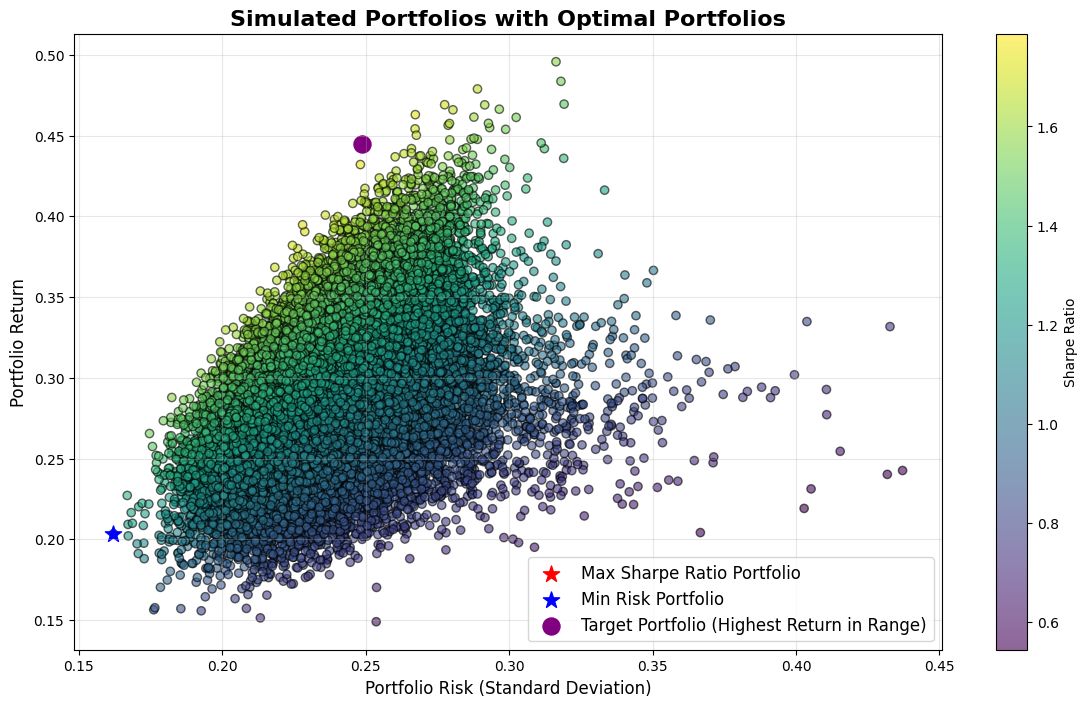

In [115]:
# 5. Plotting Optimal Portfolios with Target Portfolio
plt.figure(figsize=(14, 8))
plt.scatter(portfolio_risks, portfolio_returns, c=sharpe_ratios, cmap='viridis', alpha=0.6, edgecolor='k')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_risk, max_sharpe_return, color='red', marker='*', s=150, label='Max Sharpe Ratio Portfolio')
plt.scatter(min_risk_risk, min_risk_return, color='blue', marker='*', s=150, label='Min Risk Portfolio')

# Plot Target Portfolio if it exists
if target_risk is not None and target_return is not None:
    plt.scatter(target_risk, target_return, color='purple', marker='o', s=150, label='Target Portfolio (Highest Return in Range)')

plt.title("Simulated Portfolios with Optimal Portfolios", fontsize=16, fontweight='bold')
plt.xlabel("Portfolio Risk (Standard Deviation)", fontsize=12)
plt.ylabel("Portfolio Return", fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

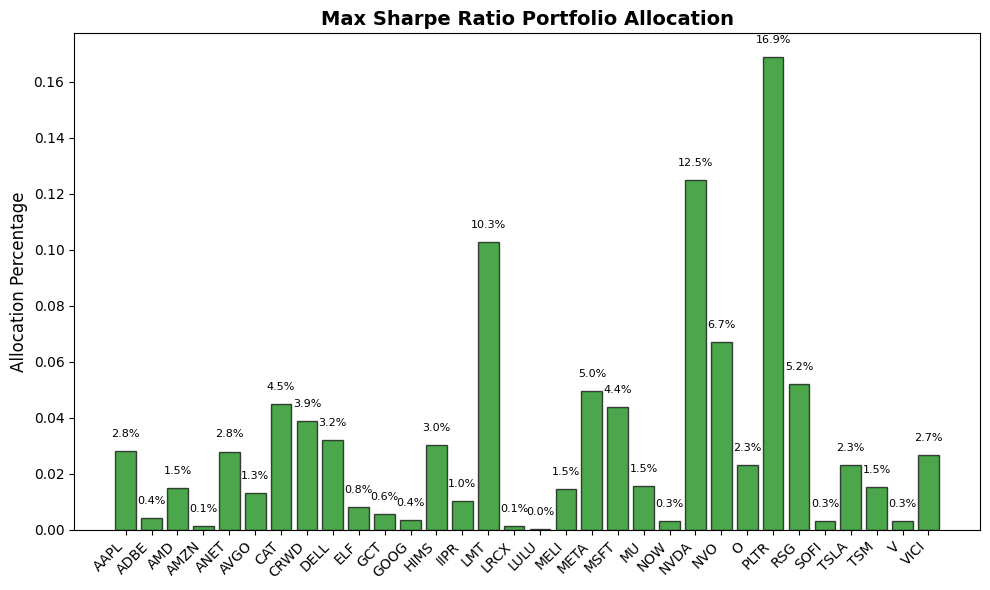

In [116]:
# 6. Plotting Allocations for Max Sharpe Ratio Portfolio
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(max_sharpe_weights)), max_sharpe_weights, color="green", alpha=0.7, edgecolor="black")
plt.title("Max Sharpe Ratio Portfolio Allocation", fontsize=14, fontweight="bold")
plt.ylabel("Allocation Percentage", fontsize=12)
plt.xticks(np.arange(len(max_sharpe_weights)), data.columns, rotation=45, ha="right", fontsize=10)
for i, weight in enumerate(max_sharpe_weights):
    plt.text(i, weight + 0.005, f"{weight*100:.1f}%", ha="center", fontsize=8)
plt.tight_layout()
plt.show()

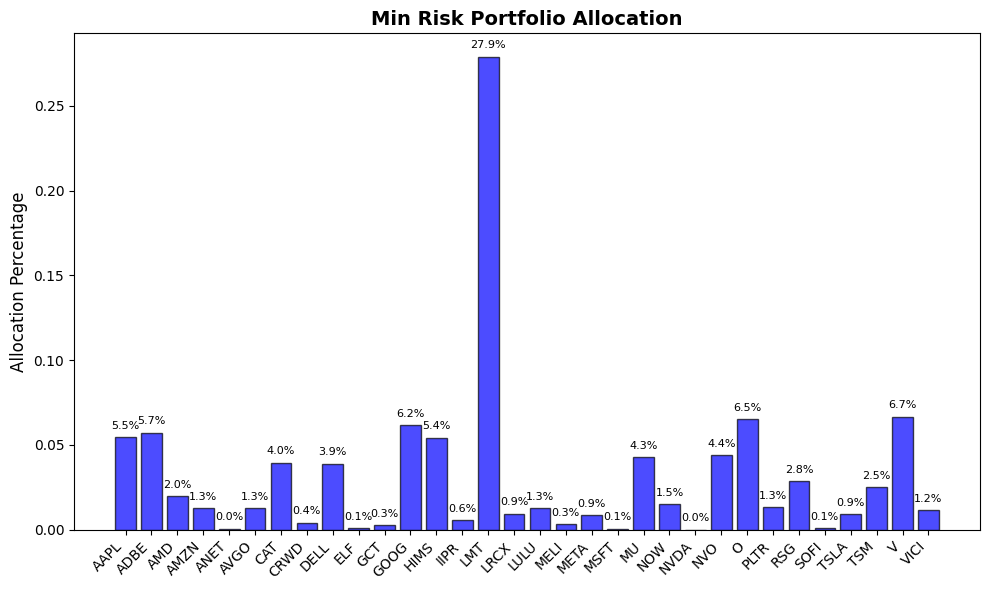

In [117]:
# 7. Plotting Allocations for Minimum Risk Portfolio
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(min_risk_weights)), min_risk_weights, color="blue", alpha=0.7, edgecolor="black")
plt.title("Min Risk Portfolio Allocation", fontsize=14, fontweight="bold")
plt.ylabel("Allocation Percentage", fontsize=12)
plt.xticks(np.arange(len(min_risk_weights)), data.columns, rotation=45, ha="right", fontsize=10)
for i, weight in enumerate(min_risk_weights):
    plt.text(i, weight + 0.005, f"{weight*100:.1f}%", ha="center", fontsize=8)
plt.tight_layout()
plt.show()

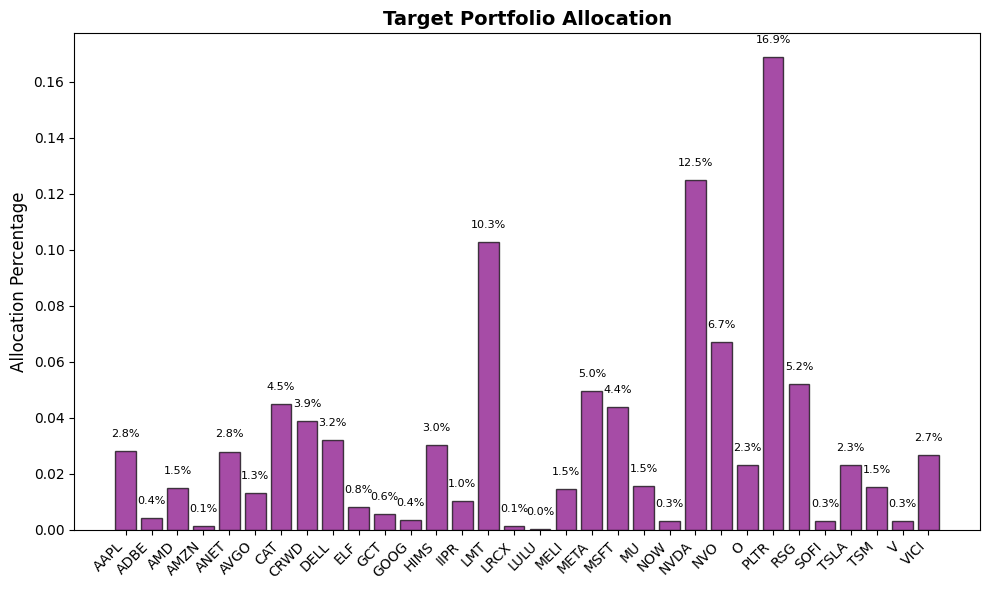

In [118]:
# 8. Plotting Allocations for Target Portfolio (Highest Return within Risk Range)
if target_risk is not None and target_return is not None:
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(target_weights)), target_weights, color="purple", alpha=0.7, edgecolor="black")
    plt.title("Target Portfolio Allocation", fontsize=14, fontweight="bold")
    plt.ylabel("Allocation Percentage", fontsize=12)
    plt.xticks(np.arange(len(target_weights)), data.columns, rotation=45, ha="right", fontsize=10)
    for i, weight in enumerate(target_weights):
        plt.text(i, weight + 0.005, f"{weight*100:.1f}%", ha="center", fontsize=8)
    plt.tight_layout()
    plt.show()